In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
import pickle as pkl
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from medmnist import INFO
import torch
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, accuracy_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from utils import train_load_datasets_resnet as tr
import UQ_toolbox as uq

In [3]:
with open('/mnt/data/psteinmetz/archive_notebooks/Documents/model_global_perfs.pkl', 'rb') as f:
    results = pkl.load(f)

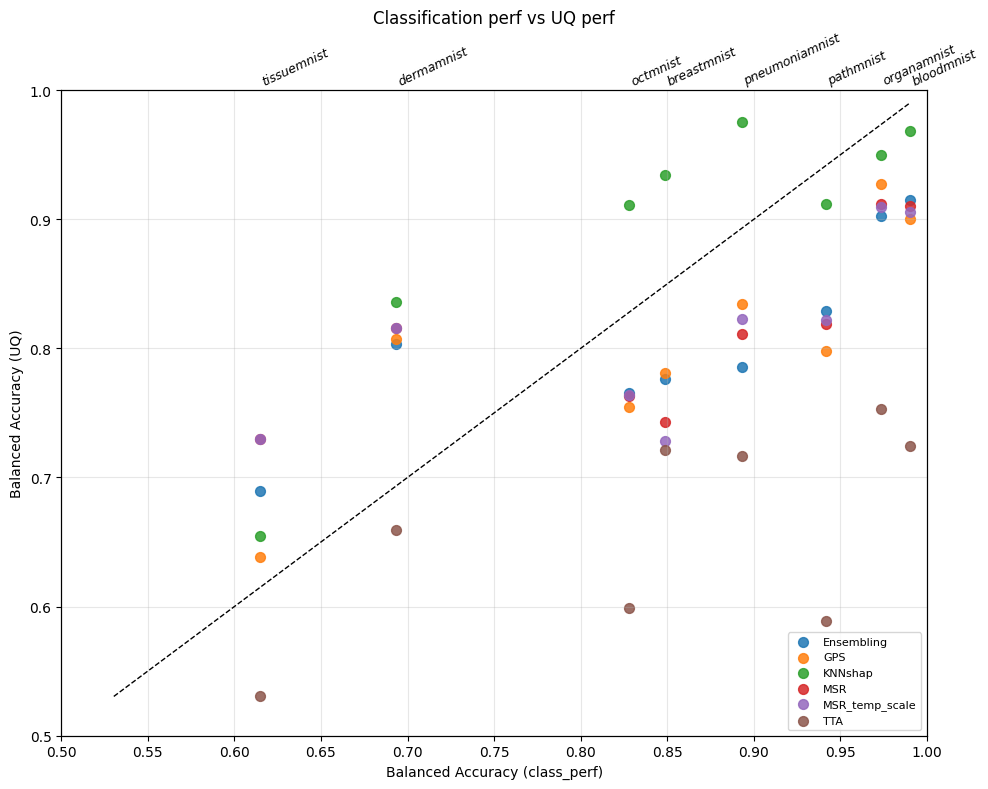

In [4]:
def to_scalar(val):
    if val is None:
        return np.nan
    if isinstance(val, (int, float, np.floating)):
        return float(val)
    if isinstance(val, np.ndarray):
        return float(np.nanmean(val)) if val.size else np.nan
    if isinstance(val, (list, tuple)):
        return float(np.nanmean(val)) if len(val) else np.nan
    if isinstance(val, dict):
        if 'mean' in val and isinstance(val['mean'], (int, float, np.floating)):
            return float(val['mean'])
        return float(np.nanmean(list(val.values()))) if len(val) else np.nan
    try:
        return float(val)
    except Exception:
        return np.nan

# Collect points per method across all datasets + x tick mapping
method_to_xy = {}        # method -> (xs, ys)
ds_to_x = {}             # dataset -> x (balanced_accuracy)
for ds in sorted(results.keys()):
    try:
        x_src = results[ds]['class_perf']['balanced_accuracy']
        y_src = results[ds]['balanced_acc_UQ']
    except KeyError:
        continue

    x = to_scalar(x_src)
    if not np.isfinite(x):
        continue
    ds_to_x[ds] = x

    if isinstance(y_src, dict):
        items = list(y_src.items())
    elif isinstance(y_src, (list, tuple)) and y_src and isinstance(y_src[0], (list, tuple)) and len(y_src[0]) == 2:
        items = y_src
    else:
        items = [('UQ', y_src)]

    for method, val in items:
        y = to_scalar(val)
        if not np.isfinite(y):
            continue
        xs, ys = method_to_xy.setdefault(method, ([], []))
        xs.append(x); ys.append(y)

if not method_to_xy:
    print("No valid points to plot.")
else:
    plt.figure(figsize=(10,8))
    for method, (xs, ys) in sorted(method_to_xy.items()):
        plt.scatter(xs, ys, s=50, alpha=0.85, label=method)

    # Identity line
    all_x = [x for xs, _ in method_to_xy.values() for x in xs]
    all_y = [y for _, ys in method_to_xy.values() for y in ys]
    mn, mx = min(all_x + all_y), max(all_x + all_y)
    mn, mx = max(0.0, mn), min(1.0, mx)
    plt.plot([mn, mx], [mn, mx], 'k--', lw=1)

    # Axes, labels
    plt.xlim(0.5, 1); plt.ylim(0.5, 1)
    plt.xlabel('Balanced Accuracy (class_perf)')
    plt.ylabel('Balanced Accuracy (UQ)')
    plt.title('Classification perf vs UQ perf')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right', fontsize=8, frameon=True)

    ax = plt.gca()

    # Bottom: numeric ticks
    ax.set_xlim(0.5, 1.0)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.05))
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='x', which='major', labelbottom=True)

    # Top: dataset names at their x positions
    if ds_to_x:
        pairs = sorted(ds_to_x.items(), key=lambda kv: kv[1])
        tickpos = [v for _, v in pairs]
        ticklabels = [k for k, _ in pairs]

        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(tickpos)
        ax_top.set_xticklabels(ticklabels, rotation=25, ha='left', fontsize=9, fontstyle='oblique')
        ax_top.tick_params(axis='x', length=0, pad=2)

    plt.tight_layout()
    # If labels are cut off, add a bit more top margin:
    # plt.subplots_adjust(top=0.88)
    plt.show()

In [5]:
def apply_softmax(y):
    y_scores = np.array(F.softmax(torch.tensor(y), dim=1))
    return y_scores

In [6]:
def test_eval(test_loader, device, models, data_flag):
    info = INFO[data_flag]
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes

    # Perform inference on the test set
    y_true = []
    y_scores = []
    y_raw_digits = []
    indiv_scores = [[] for _ in range(len(models))]  # Store individual model scores

    for m in models:
        m.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = [model(data) for model in models]

            # Store individual model scores
            for i, output in enumerate(outputs):
                if task_type == 'binary-class':
                    indiv_scores[i].extend(F.sigmoid(output).cpu().numpy().flatten())
                else:
                    indiv_scores[i].extend(F.softmax(output, dim=1).cpu().numpy())

            # Average the outputs for ensemble prediction
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            y_true.extend(target.cpu().numpy().flatten())
            if task_type == 'binary-class':
                avg_output_sig = F.sigmoid(avg_output)
                y_scores.extend(avg_output_sig.cpu().numpy().flatten())
                y_raw_digits.extend(avg_output.cpu().numpy().flatten())
            else:
                y_scores.extend(avg_output.cpu().numpy())
                y_raw_digits.extend(avg_output.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_scores_raw_digits = np.array(y_raw_digits)

    if task_type == 'binary-class':
        y_pred = (y_scores > 0.5).astype(int)
        auc = roc_auc_score(y_true, y_scores)
    else:
        y_pred = np.argmax(y_scores, axis=1)
        # Calculate metrics
        auc = roc_auc_score(y_true, apply_softmax(y_scores), multi_class='ovr')
    acc = accuracy_score(y_true, y_pred)
    print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

    # Generate the confusion matrix
    if task_type == 'binary-class':
        cm = confusion_matrix(y_true, y_pred)
    else:
        cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute balanced accuracy
    if task_type == 'binary-class':
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
    else:
        balanced_acc = balanced_accuracy_score(y_true, y_scores.argmax(axis=1))

    # Compute sensitivity (recall)
    if task_type == 'binary-class':
        sensitivity = recall_score(y_true, y_pred, average='binary')
    else:
        sensitivity = recall_score(y_true, y_scores.argmax(axis=1), average='macro')
    

    # Compute specificity
    specificities = []
    for i in range(num_classes):
        if task_type == 'binary-class':
            cm = confusion_matrix(y_true, y_pred)
        else:
            cm = confusion_matrix(y_true, y_scores.argmax(axis=1))
        FP = np.sum(cm[:, i]) - cm[i, i]  # False Positives
        TN = np.sum(cm) - (np.sum(cm[i, :]) + FP)  # True Negatives
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 1.0
        specificities.append(specificity)

    macro_specificity = np.mean(specificities)

    perfs = {
        'auc': auc,
        'accuracy': acc,
        'balanced_accuracy': balanced_acc,
        'sensitivity': sensitivity,
        'specificity': macro_specificity,
        'confusion_matrix': cm
    }
    print(perfs)
    return y_true, y_scores, y_scores_raw_digits, indiv_scores, perfs

In [7]:
# Add picklable callables
class RepeatGrayToRGB:
    def __call__(self, x):
        return x.repeat(3, 1, 1)

Processing breastmnist with color=False and activation=sigmoid
Training dataset size: 499
Calibration dataset size: 125
Training dataset size: 499
Calibration dataset size: 125
Ensemble AUC: 0.919, Ensemble Accuracy: 0.878


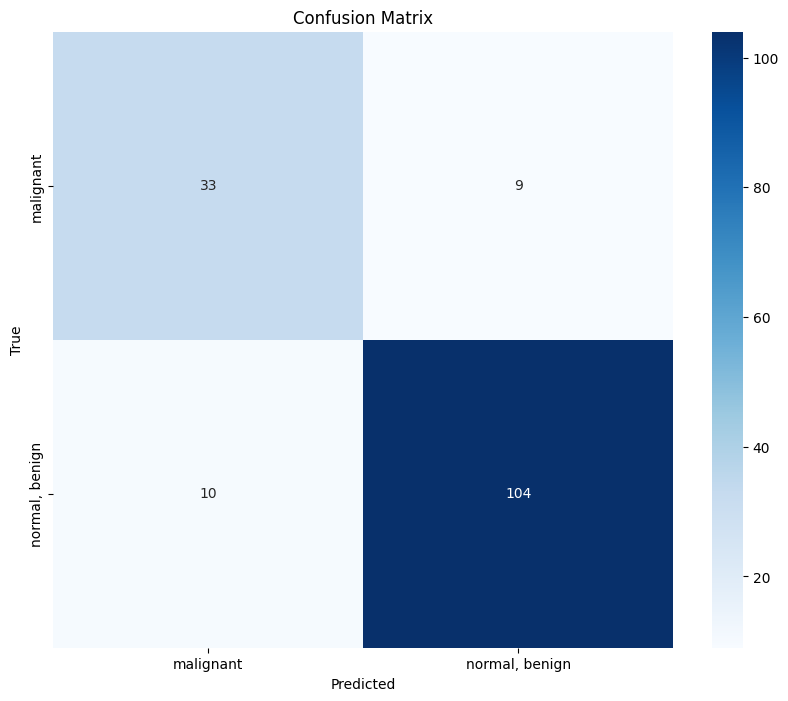

{'auc': np.float64(0.9189640768588136), 'accuracy': 0.8782051282051282, 'balanced_accuracy': np.float64(0.8489974937343359), 'sensitivity': 0.9122807017543859, 'specificity': np.float64(0.8489974937343359), 'confusion_matrix': array([[ 33,   9],
       [ 10, 104]])}
Ensemble AUC: 0.949, Ensemble Accuracy: 0.888


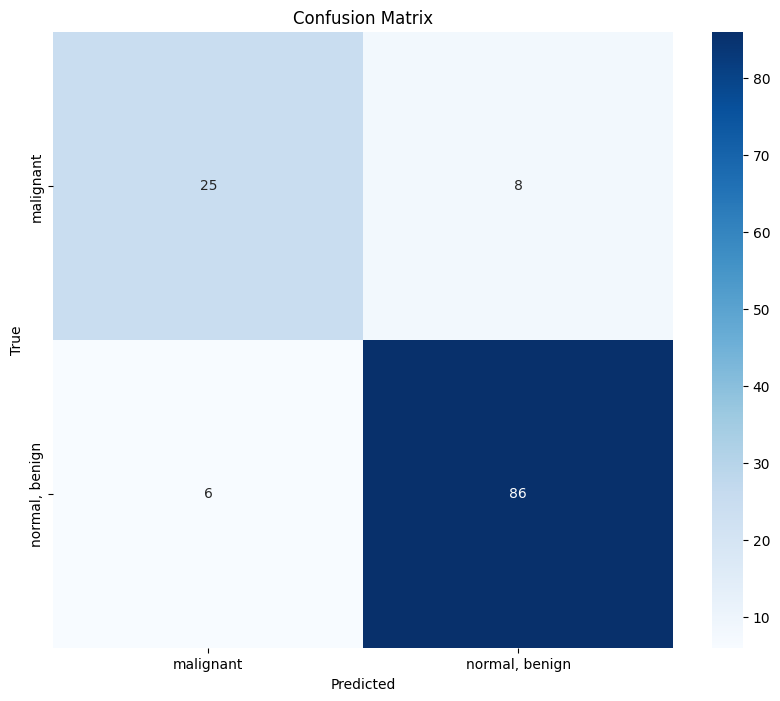

{'auc': np.float64(0.9486166007905138), 'accuracy': 0.888, 'balanced_accuracy': np.float64(0.8461791831357048), 'sensitivity': 0.9347826086956522, 'specificity': np.float64(0.8461791831357048), 'confusion_matrix': array([[25,  8],
       [ 6, 86]])}
Processing organamnist with color=False and activation=softmax
Training dataset size: 32841
Calibration dataset size: 8211
Training dataset size: 32841
Calibration dataset size: 8211


/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.999, Ensemble Accuracy: 0.977


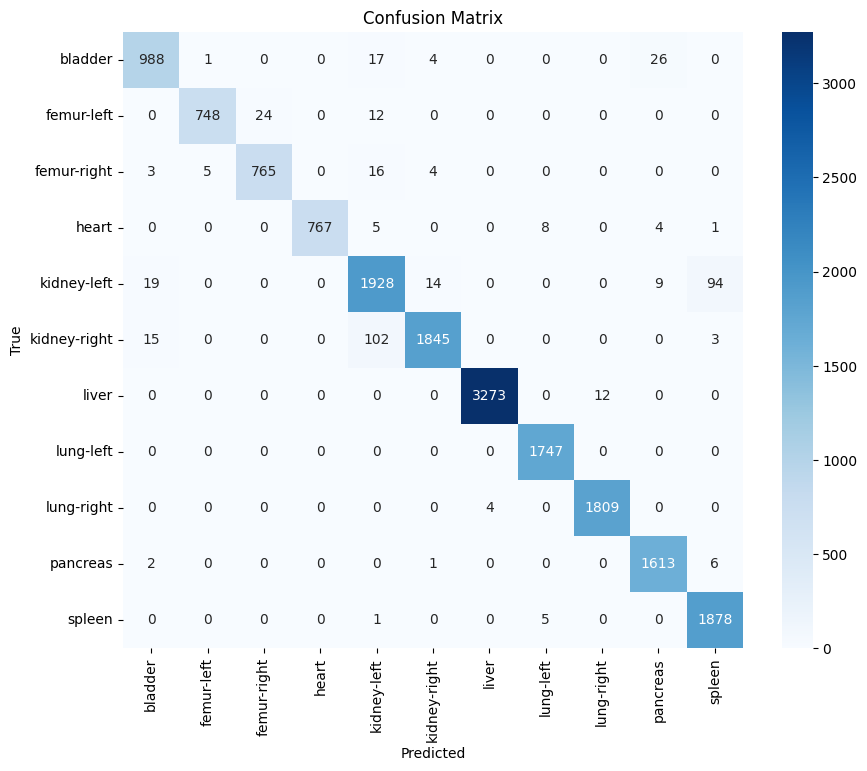

{'auc': np.float64(0.9994998659930716), 'accuracy': 0.97654404319946, 'balanced_accuracy': np.float64(0.9734507133527501), 'sensitivity': 0.9734507133527501, 'specificity': np.float64(0.9976288663557393), 'confusion_matrix': array([[ 988,    1,    0,    0,   17,    4,    0,    0,    0,   26,    0],
       [   0,  748,   24,    0,   12,    0,    0,    0,    0,    0,    0],
       [   3,    5,  765,    0,   16,    4,    0,    0,    0,    0,    0],
       [   0,    0,    0,  767,    5,    0,    0,    8,    0,    4,    1],
       [  19,    0,    0,    0, 1928,   14,    0,    0,    0,    9,   94],
       [  15,    0,    0,    0,  102, 1845,    0,    0,    0,    0,    3],
       [   0,    0,    0,    0,    0,    0, 3273,    0,   12,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 1747,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    4,    0, 1809,    0,    0],
       [   2,    0,    0,    0,    0,    1,    0,    0,    0, 1613,    6],
       [   0,    0,    0,

/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 1.000, Ensemble Accuracy: 0.999


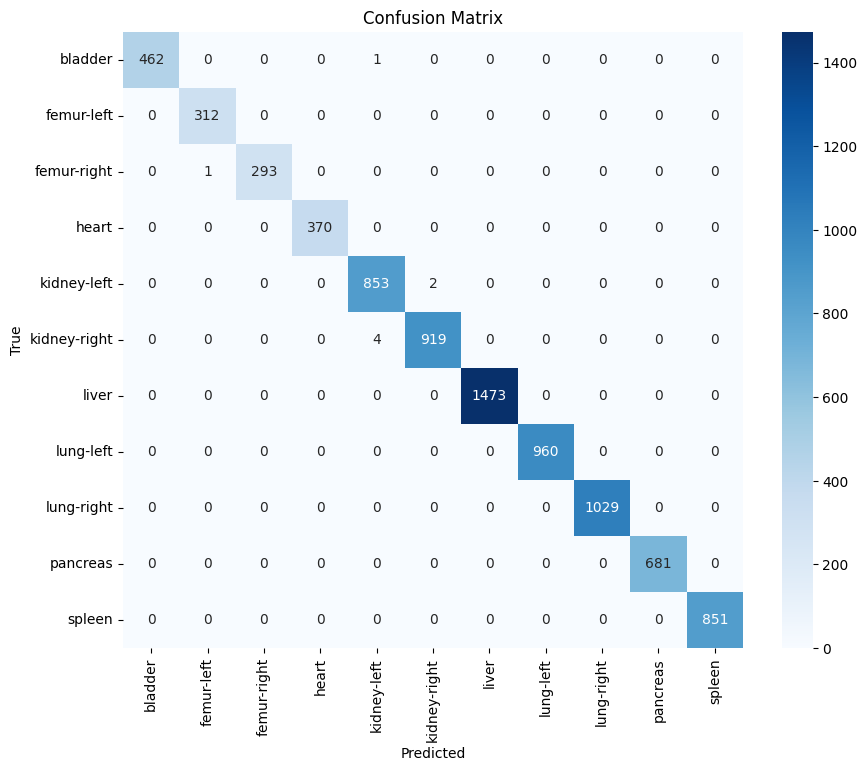

{'auc': np.float64(0.9999969500319612), 'accuracy': 0.9990256972354159, 'balanced_accuracy': np.float64(0.9988878124073518), 'sensitivity': 0.9988878124073518, 'specificity': np.float64(0.9999017509771435), 'confusion_matrix': array([[ 462,    0,    0,    0,    1,    0,    0,    0,    0,    0,    0],
       [   0,  312,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    1,  293,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,  370,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,  853,    2,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    4,  919,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1473,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,  960,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1029,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  681,    0],
       [   0,    0,    

/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Training dataset size: 4185
Calibration dataset size: 1047
Training dataset size: 4185
Calibration dataset size: 1047
Ensemble AUC: 0.990, Ensemble Accuracy: 0.920


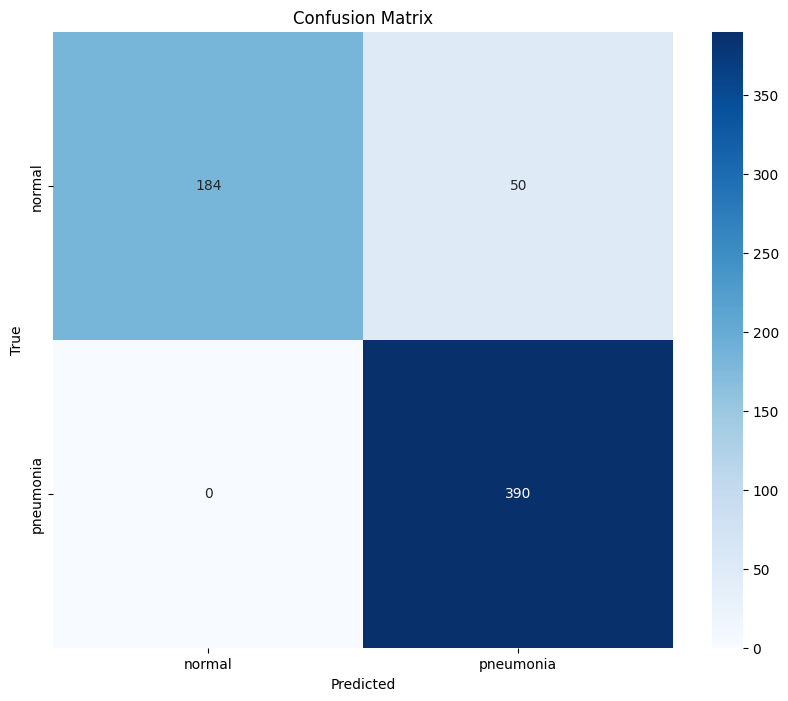

{'auc': np.float64(0.989831251369713), 'accuracy': 0.9198717948717948, 'balanced_accuracy': np.float64(0.8931623931623931), 'sensitivity': 1.0, 'specificity': np.float64(0.8931623931623931), 'confusion_matrix': array([[184,  50],
       [  0, 390]])}
Ensemble AUC: 0.999, Ensemble Accuracy: 0.989


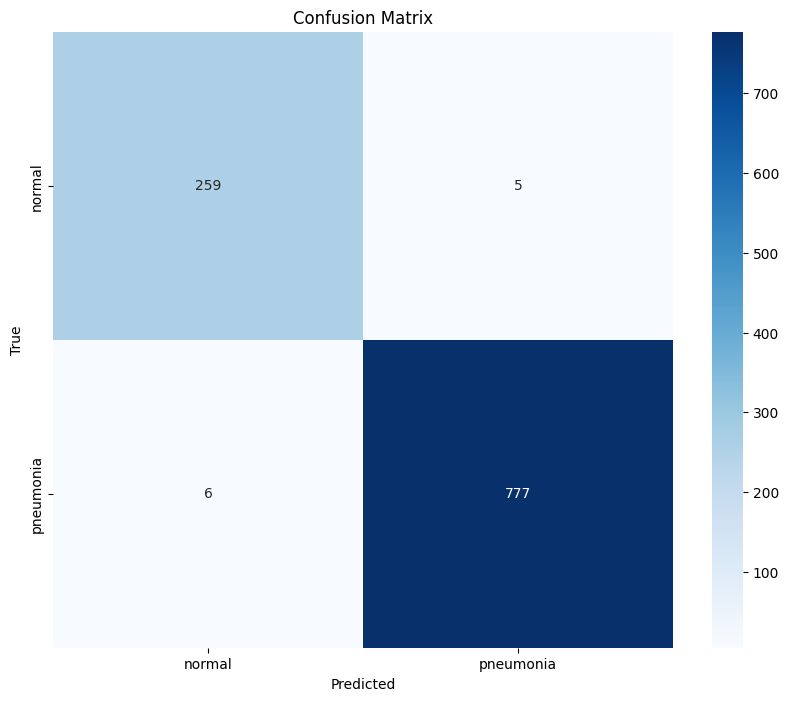

{'auc': np.float64(0.9987373737373737), 'accuracy': 0.9894937917860553, 'balanced_accuracy': np.float64(0.986698885405782), 'sensitivity': 0.9923371647509579, 'specificity': np.float64(0.986698885405782), 'confusion_matrix': array([[259,   5],
       [  6, 777]])}
Processing dermamnist with color=True and activation=softmax
Training dataset size: 6408
Calibration dataset size: 1602
Training dataset size: 6408
Calibration dataset size: 1602


/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.974, Ensemble Accuracy: 0.866


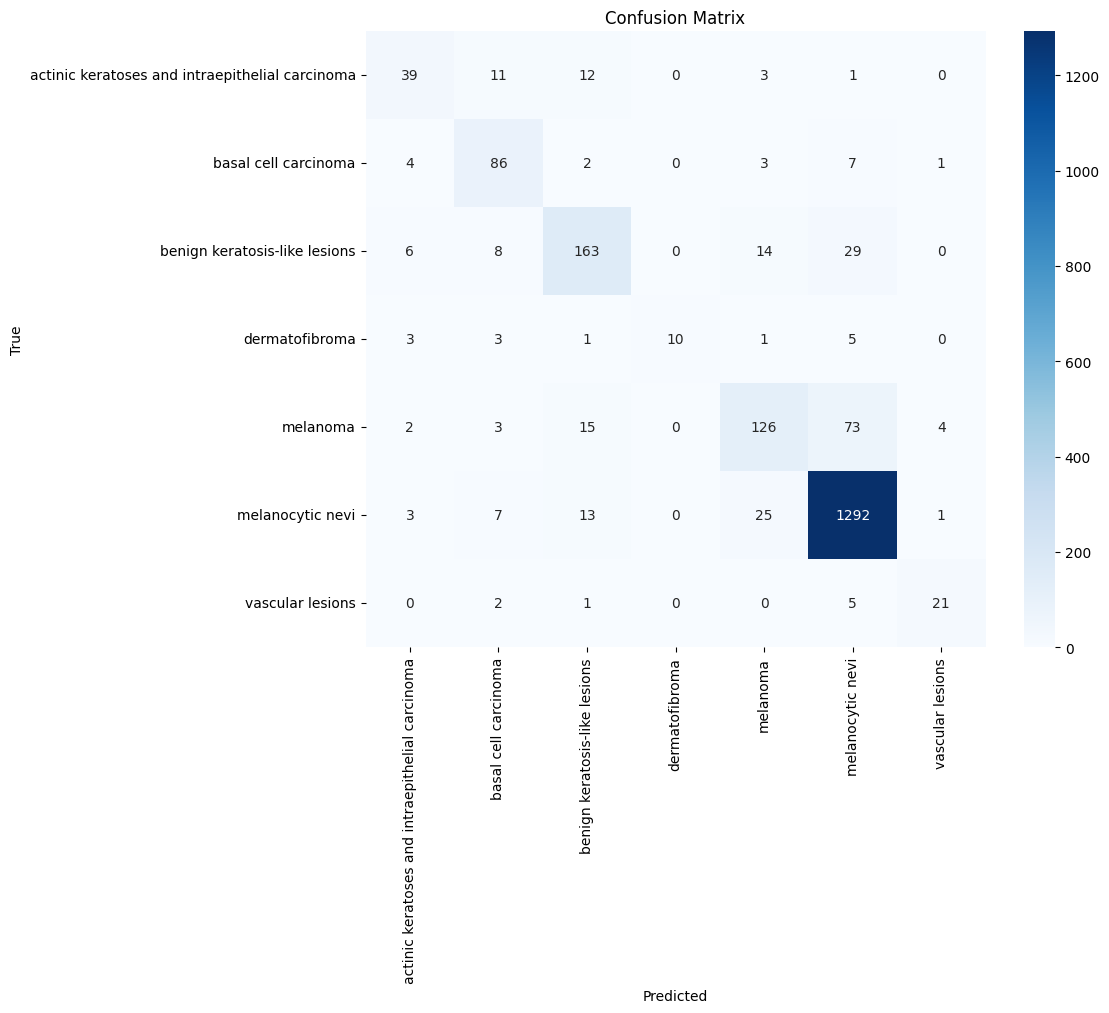

{'auc': np.float64(0.9736996347569223), 'accuracy': 0.8663341645885286, 'balanced_accuracy': np.float64(0.693453243397623), 'sensitivity': 0.693453243397623, 'specificity': np.float64(0.9626597232916266), 'confusion_matrix': array([[  39,   11,   12,    0,    3,    1,    0],
       [   4,   86,    2,    0,    3,    7,    1],
       [   6,    8,  163,    0,   14,   29,    0],
       [   3,    3,    1,   10,    1,    5,    0],
       [   2,    3,   15,    0,  126,   73,    4],
       [   3,    7,   13,    0,   25, 1292,    1],
       [   0,    2,    1,    0,    0,    5,   21]])}


/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.970, Ensemble Accuracy: 0.859


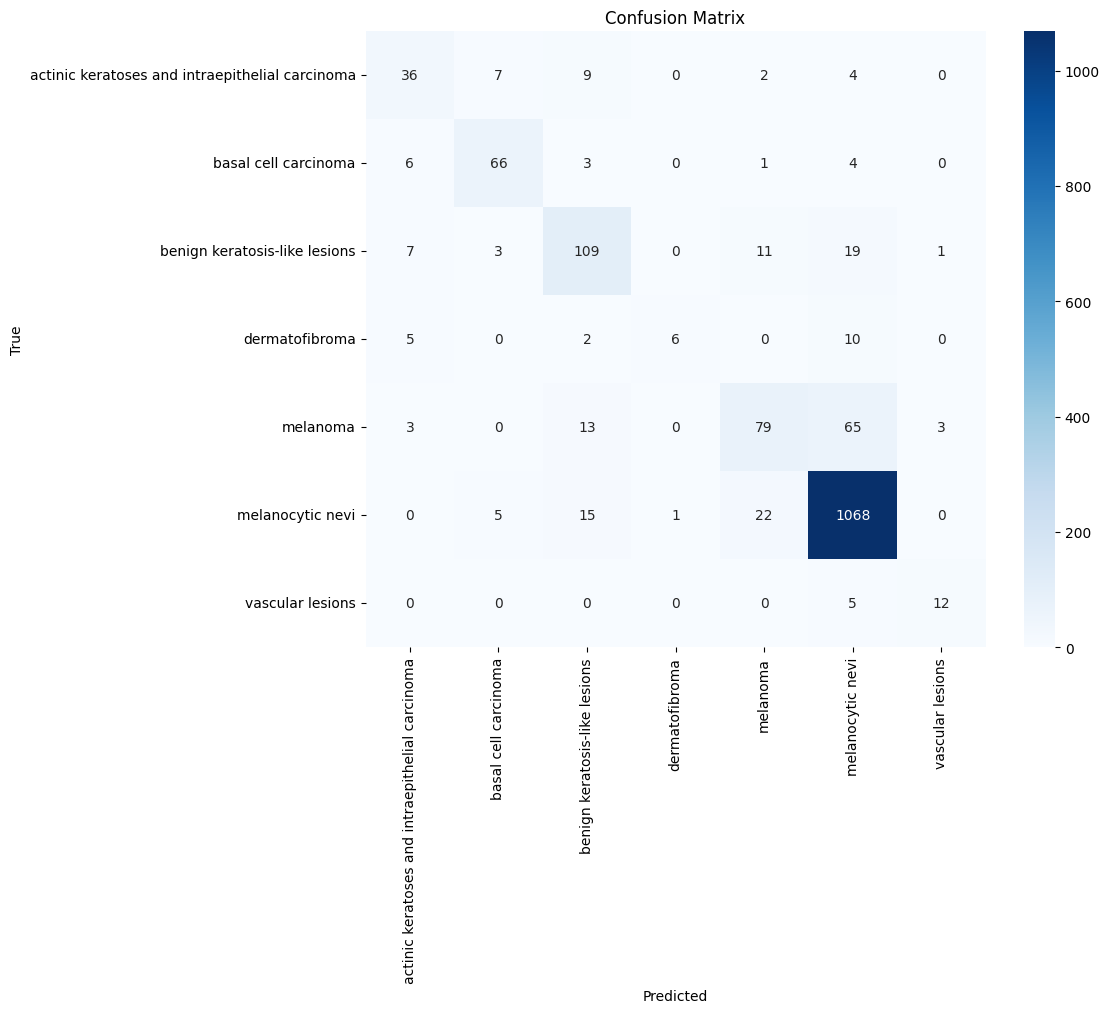

{'auc': np.float64(0.9704562844422462), 'accuracy': 0.8589263420724095, 'balanced_accuracy': np.float64(0.655009563756818), 'sensitivity': 0.655009563756818, 'specificity': np.float64(0.9573601341308037), 'confusion_matrix': array([[  36,    7,    9,    0,    2,    4,    0],
       [   6,   66,    3,    0,    1,    4,    0],
       [   7,    3,  109,    0,   11,   19,    1],
       [   5,    0,    2,    6,    0,   10,    0],
       [   3,    0,   13,    0,   79,   65,    3],
       [   0,    5,   15,    1,   22, 1068,    0],
       [   0,    0,    0,    0,    0,    5,   12]])}
Processing octmnist with color=False and activation=softmax


/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Training dataset size: 86647
Calibration dataset size: 21662
Training dataset size: 86647
Calibration dataset size: 21662
Ensemble AUC: 0.989, Ensemble Accuracy: 0.828


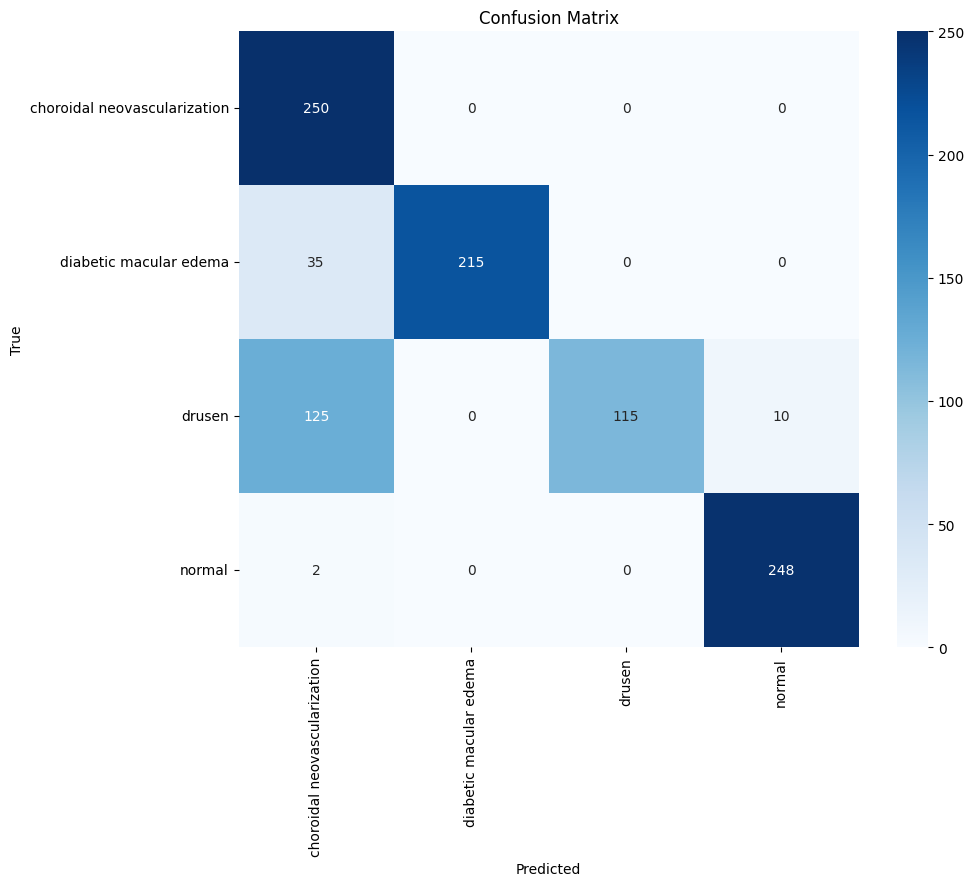

{'auc': np.float64(0.9894253333333334), 'accuracy': 0.828, 'balanced_accuracy': np.float64(0.828), 'sensitivity': 0.828, 'specificity': np.float64(0.9426666666666667), 'confusion_matrix': array([[250,   0,   0,   0],
       [ 35, 215,   0,   0],
       [125,   0, 115,  10],
       [  2,   0,   0, 248]])}
Ensemble AUC: 0.998, Ensemble Accuracy: 0.978


/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


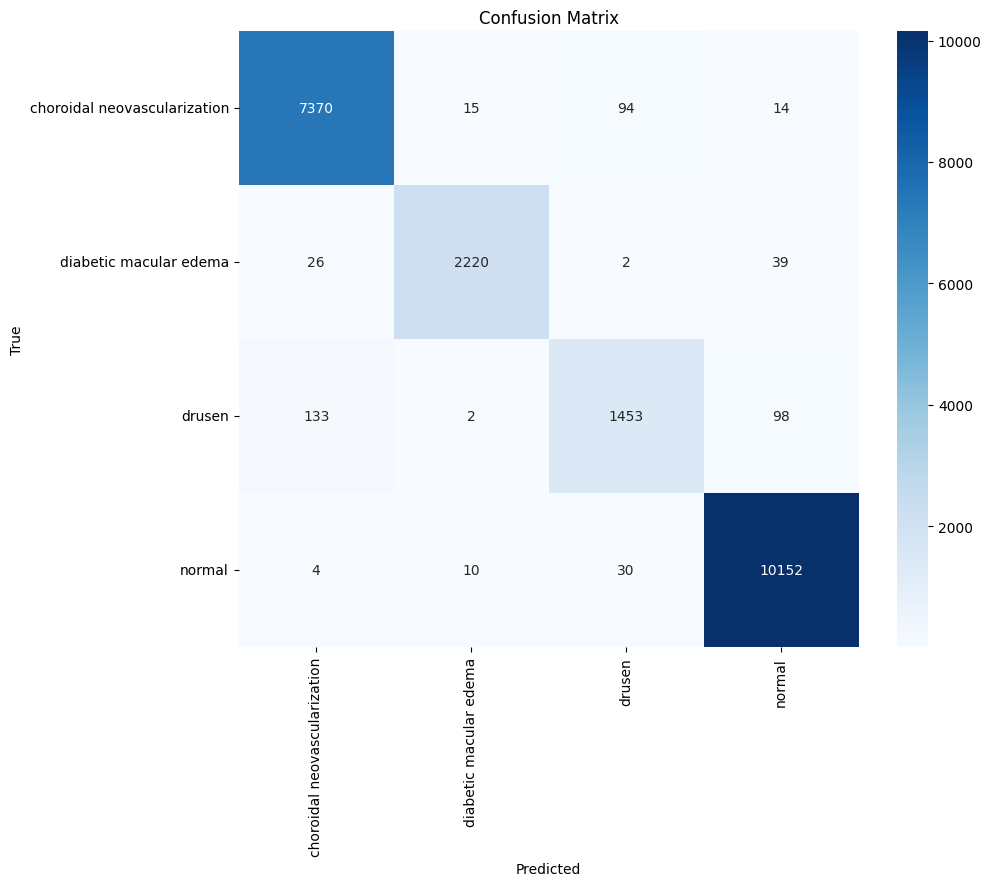

/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


{'auc': np.float64(0.9977831483916445), 'accuracy': 0.9784415104791802, 'balanced_accuracy': np.float64(0.9529440811144193), 'sensitivity': 0.9529440811144193, 'specificity': np.float64(0.9919063811598149), 'confusion_matrix': array([[ 7370,    15,    94,    14],
       [   26,  2220,     2,    39],
       [  133,     2,  1453,    98],
       [    4,    10,    30, 10152]])}
Processing pathmnist with color=True and activation=softmax
Training dataset size: 80000
Calibration dataset size: 20000
Training dataset size: 80000
Calibration dataset size: 20000
Ensemble AUC: 0.993, Ensemble Accuracy: 0.959


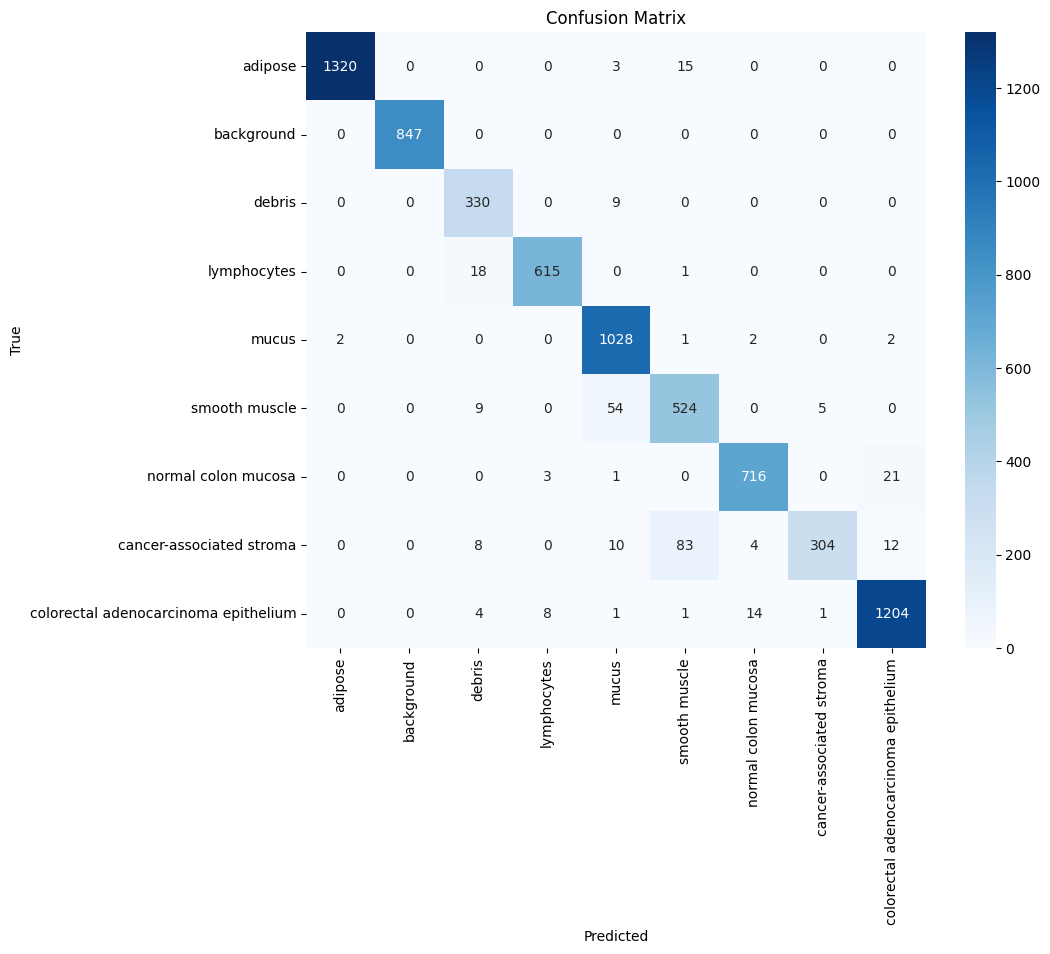

{'auc': np.float64(0.9925181675071182), 'accuracy': 0.9593314763231198, 'balanced_accuracy': np.float64(0.9414704453224735), 'sensitivity': 0.9414704453224735, 'specificity': np.float64(0.9949303406500347), 'confusion_matrix': array([[1320,    0,    0,    0,    3,   15,    0,    0,    0],
       [   0,  847,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,  330,    0,    9,    0,    0,    0,    0],
       [   0,    0,   18,  615,    0,    1,    0,    0,    0],
       [   2,    0,    0,    0, 1028,    1,    2,    0,    2],
       [   0,    0,    9,    0,   54,  524,    0,    5,    0],
       [   0,    0,    0,    3,    1,    0,  716,    0,   21],
       [   0,    0,    8,    0,   10,   83,    4,  304,   12],
       [   0,    0,    4,    8,    1,    1,   14,    1, 1204]])}


/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 1.000, Ensemble Accuracy: 0.996


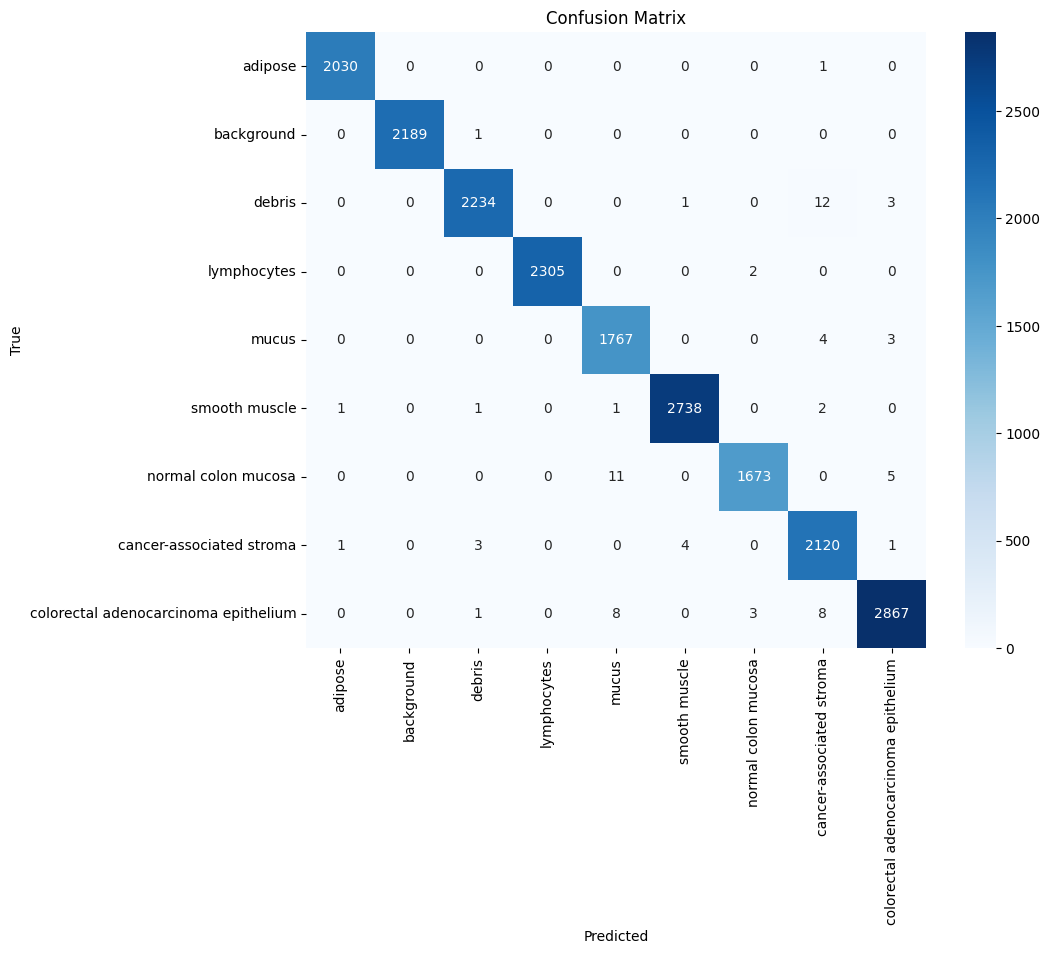

{'auc': np.float64(0.9999795877649343), 'accuracy': 0.99615, 'balanced_accuracy': np.float64(0.996075140204652), 'sensitivity': 0.996075140204652, 'specificity': np.float64(0.9995198321392631), 'confusion_matrix': array([[2030,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0, 2189,    1,    0,    0,    0,    0,    0,    0],
       [   0,    0, 2234,    0,    0,    1,    0,   12,    3],
       [   0,    0,    0, 2305,    0,    0,    2,    0,    0],
       [   0,    0,    0,    0, 1767,    0,    0,    4,    3],
       [   1,    0,    1,    0,    1, 2738,    0,    2,    0],
       [   0,    0,    0,    0,   11,    0, 1673,    0,    5],
       [   1,    0,    3,    0,    0,    4,    0, 2120,    1],
       [   0,    0,    1,    0,    8,    0,    3,    8, 2867]])}
Processing bloodmnist with color=True and activation=softmax


/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Training dataset size: 10936
Calibration dataset size: 2735
Training dataset size: 10936
Calibration dataset size: 2735
Ensemble AUC: 0.999, Ensemble Accuracy: 0.989


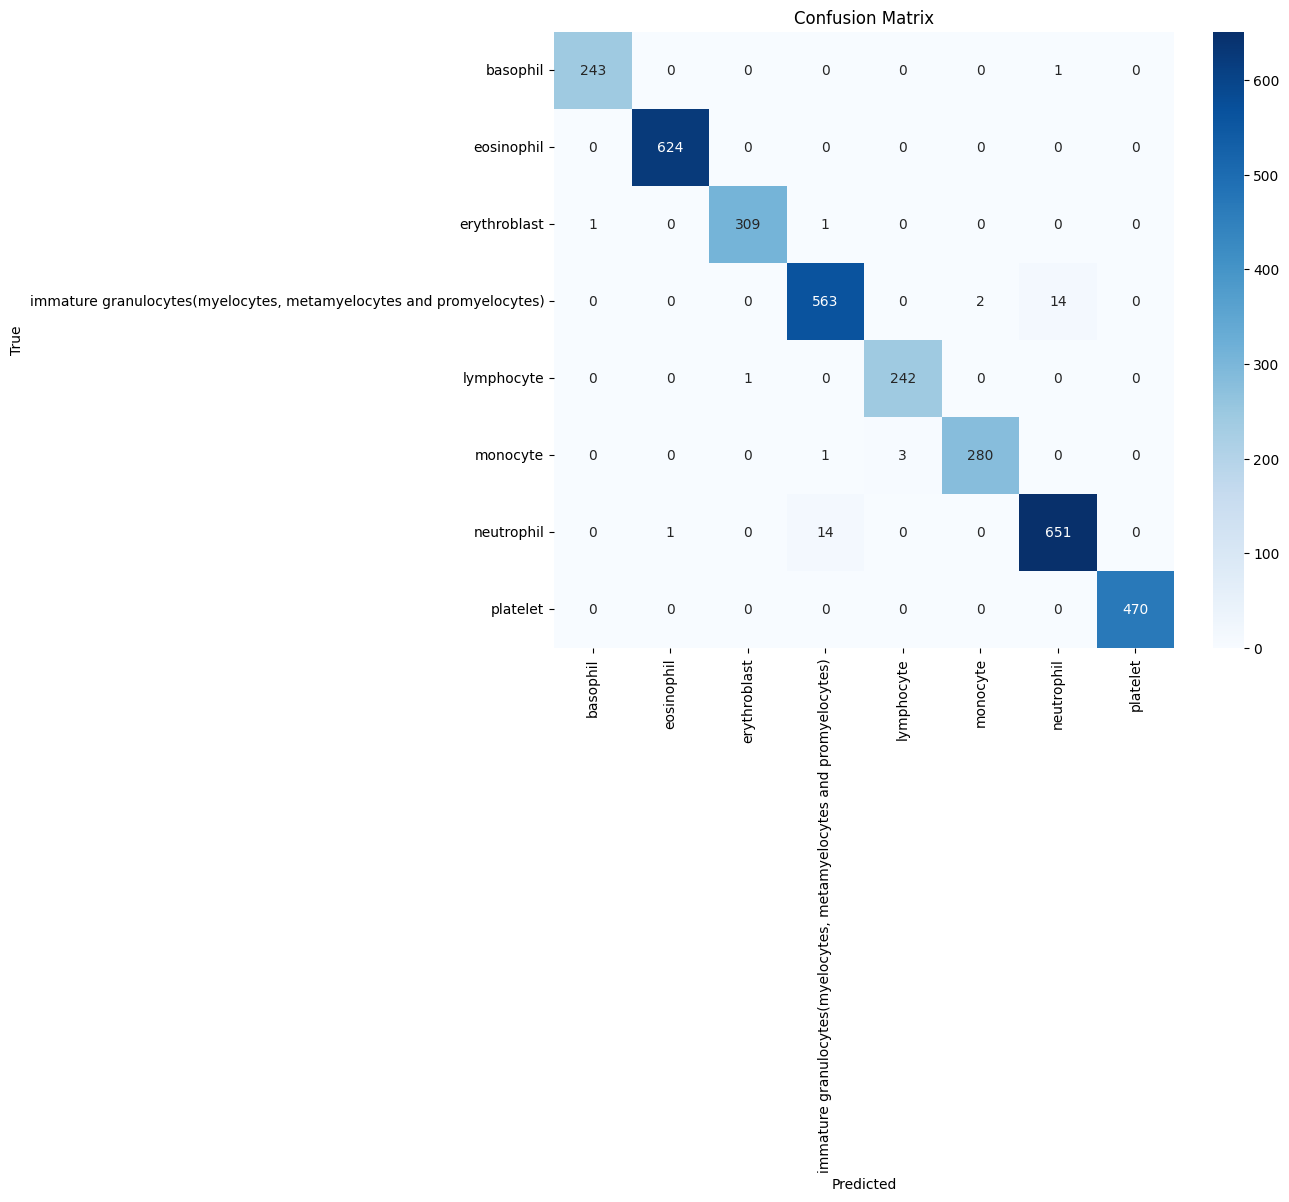

{'auc': np.float64(0.9991616129060517), 'accuracy': 0.9885998246126864, 'balanced_accuracy': np.float64(0.9901393329758483), 'sensitivity': 0.9901393329758483, 'specificity': np.float64(0.9982937677930717), 'confusion_matrix': array([[243,   0,   0,   0,   0,   0,   1,   0],
       [  0, 624,   0,   0,   0,   0,   0,   0],
       [  1,   0, 309,   1,   0,   0,   0,   0],
       [  0,   0,   0, 563,   0,   2,  14,   0],
       [  0,   0,   1,   0, 242,   0,   0,   0],
       [  0,   0,   0,   1,   3, 280,   0,   0],
       [  0,   1,   0,  14,   0,   0, 651,   0],
       [  0,   0,   0,   0,   0,   0,   0, 470]])}


/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.999, Ensemble Accuracy: 0.982


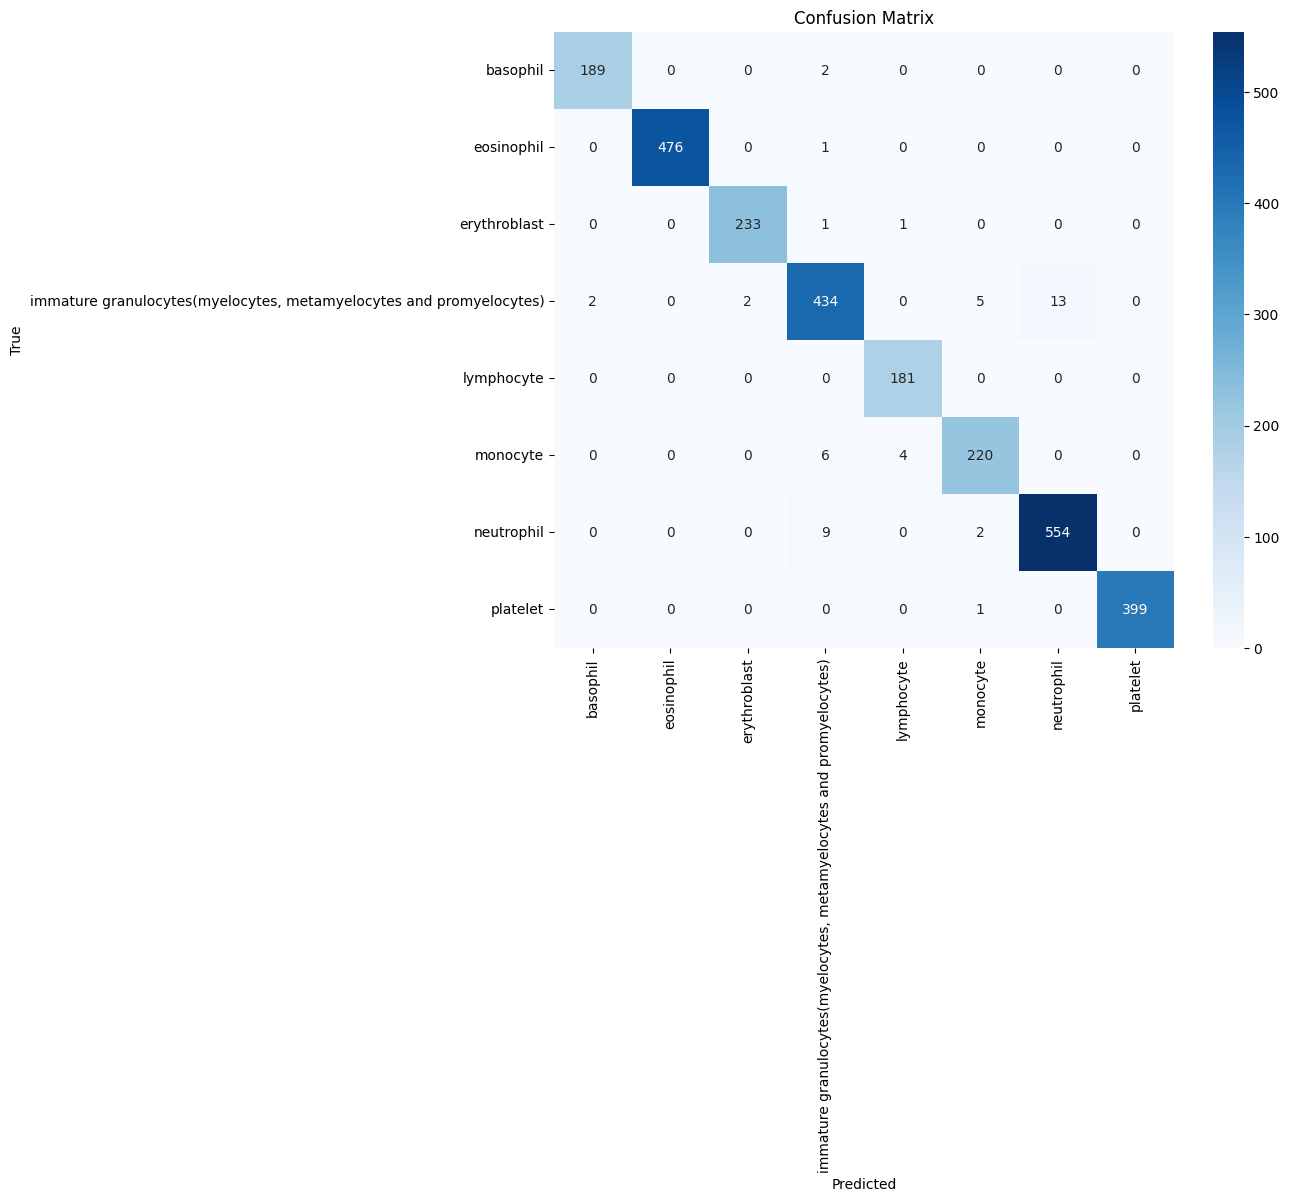

{'auc': np.float64(0.9991197391285711), 'accuracy': 0.9820840950639854, 'balanced_accuracy': np.float64(0.9831536025002026), 'sensitivity': 0.9831536025002026, 'specificity': np.float64(0.997366842124348), 'confusion_matrix': array([[189,   0,   0,   2,   0,   0,   0,   0],
       [  0, 476,   0,   1,   0,   0,   0,   0],
       [  0,   0, 233,   1,   1,   0,   0,   0],
       [  2,   0,   2, 434,   0,   5,  13,   0],
       [  0,   0,   0,   0, 181,   0,   0,   0],
       [  0,   0,   0,   6,   4, 220,   0,   0],
       [  0,   0,   0,   9,   0,   2, 554,   0],
       [  0,   0,   0,   0,   0,   1,   0, 399]])}
Processing tissuemnist with color=False and activation=softmax


/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Training dataset size: 151284
Calibration dataset size: 37822
Training dataset size: 151284
Calibration dataset size: 37822
Ensemble AUC: 0.947, Ensemble Accuracy: 0.724


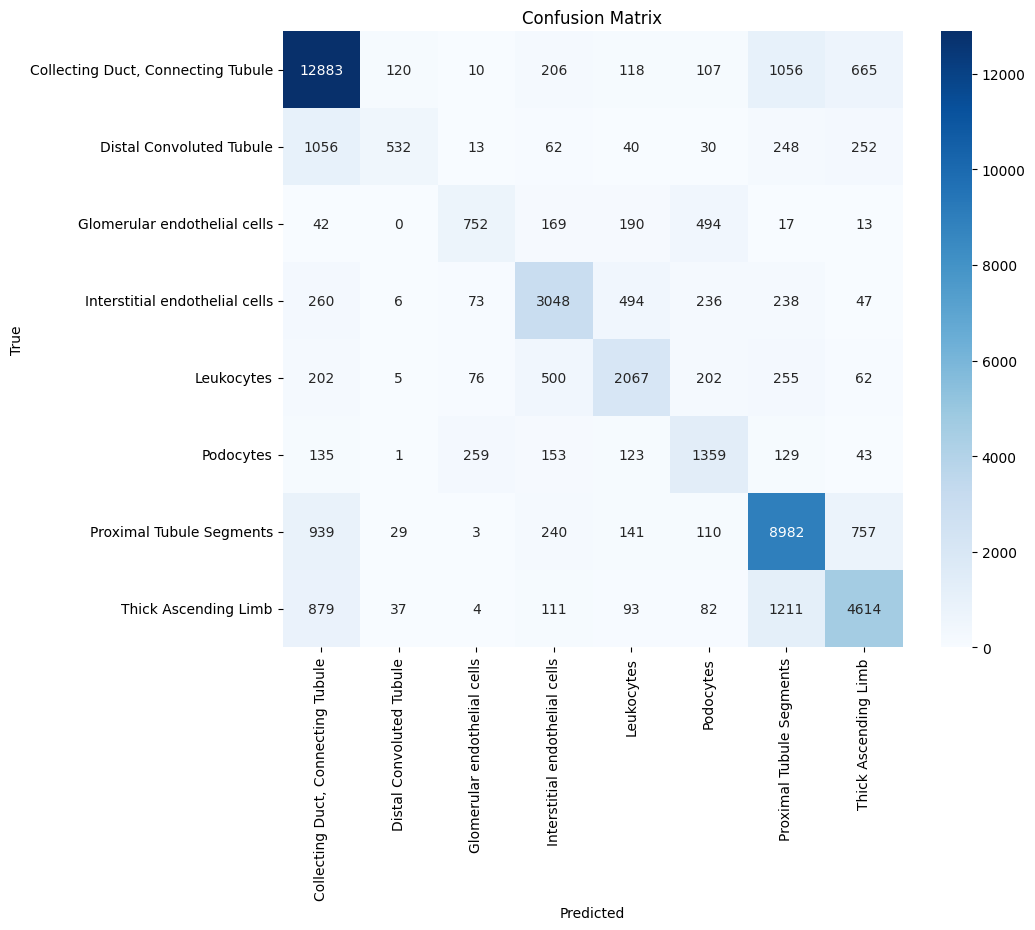

{'auc': np.float64(0.9468476360660238), 'accuracy': 0.7241328257191202, 'balanced_accuracy': np.float64(0.6146786896407591), 'sensitivity': 0.6146786896407591, 'specificity': np.float64(0.956827003647414), 'confusion_matrix': array([[12883,   120,    10,   206,   118,   107,  1056,   665],
       [ 1056,   532,    13,    62,    40,    30,   248,   252],
       [   42,     0,   752,   169,   190,   494,    17,    13],
       [  260,     6,    73,  3048,   494,   236,   238,    47],
       [  202,     5,    76,   500,  2067,   202,   255,    62],
       [  135,     1,   259,   153,   123,  1359,   129,    43],
       [  939,    29,     3,   240,   141,   110,  8982,   757],
       [  879,    37,     4,   111,    93,    82,  1211,  4614]])}


/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.948, Ensemble Accuracy: 0.729


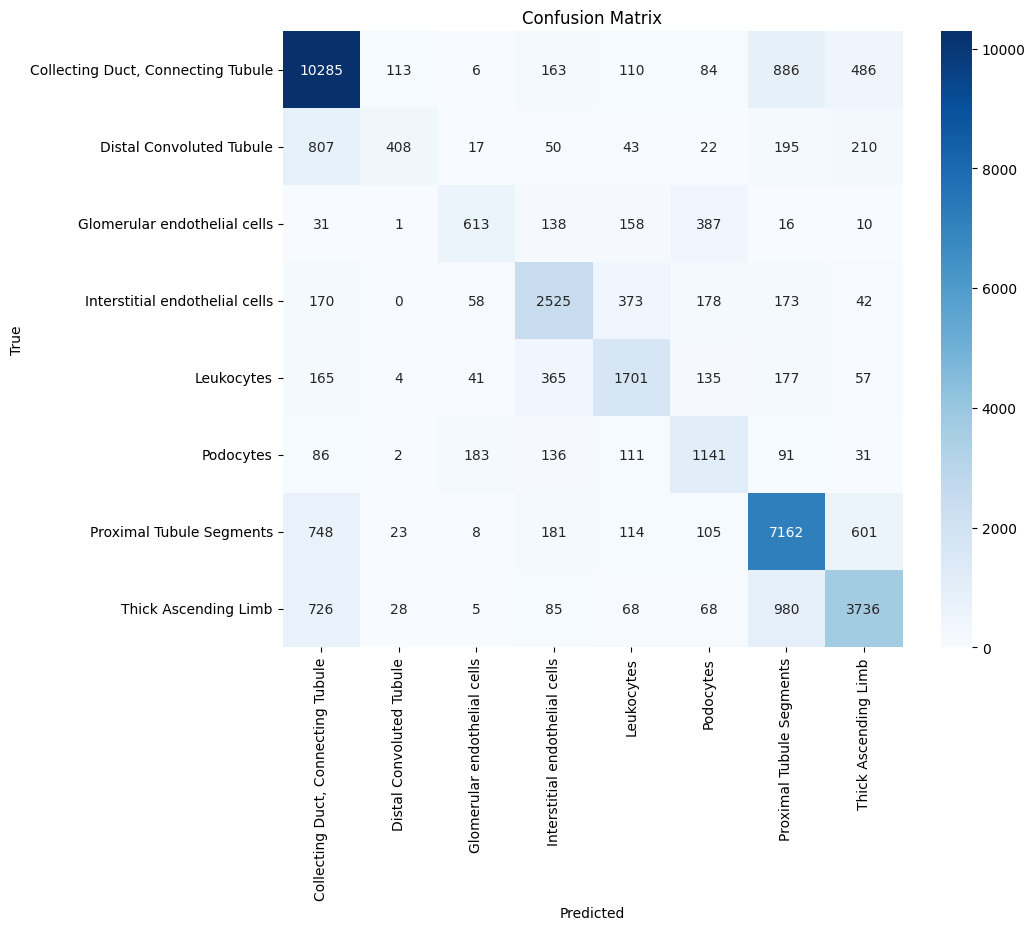

{'auc': np.float64(0.9477218365081893), 'accuracy': 0.7289672677277775, 'balanced_accuracy': np.float64(0.6239275802374751), 'sensitivity': 0.6239275802374751, 'specificity': np.float64(0.95758794578481), 'confusion_matrix': array([[10285,   113,     6,   163,   110,    84,   886,   486],
       [  807,   408,    17,    50,    43,    22,   195,   210],
       [   31,     1,   613,   138,   158,   387,    16,    10],
       [  170,     0,    58,  2525,   373,   178,   173,    42],
       [  165,     4,    41,   365,  1701,   135,   177,    57],
       [   86,     2,   183,   136,   111,  1141,    91,    31],
       [  748,    23,     8,   181,   114,   105,  7162,   601],
       [  726,    28,     5,    85,    68,    68,   980,  3736]])}


/tmp/ipykernel_688644/2663494272.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


In [8]:
flags = ['breastmnist', 'organamnist', 'pneumoniamnist', 'dermamnist', 'octmnist', 'pathmnist', 'bloodmnist', 'tissuemnist']
calib_method = ['platt', 'temperature', 'platt', 'temperature', 'temperature', 'temperature', 'temperature', 'temperature']
colors = [False, False, False, True, False, True, True, False]  # Colors for the flags
activations = ['sigmoid', 'softmax', 'sigmoid', 'softmax', 'softmax', 'softmax', 'softmax', 'softmax']  # Output activations for each flag
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
uq_methods = ['MSR', 'MSR_temp_scale', 'Ensembling', 'TTA', 'GPS', 'KNNshap']#, 'KNNshap', 'KNNall']  
size = 224  # Image size for the models
batch_size = 4000  # Batch size for the DataLoader
correct_predictions = {}
incorrect_predictions  = {}
correct_predictions_calibration = {}
incorrect_predictions_calibration = {}

for flag, color, activation, calib_method in zip(flags, colors, activations, calib_method):
    print(f"Processing {flag} with color={color} and activation={activation}")
    
    with open(f'/mnt/data/psteinmetz/archive_notebooks/Documents/medMNIST/shap/{size}*{size}/shap_results_calibration_{flag}.pkl', 'rb') as f:  # with statement avoids file leak
        shap_results = pkl.load(f)
        latent_spaces = shap_results['latent_spaces']
        shap_values_folds = shap_results['shap_values_folds']
        labels_fold = shap_results['success_folds']

    if color is True:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor()
        ])
    else:
        # For grayscale images, repeat the single channel to make it compatible with ResNet
        # ResNet expects 3 channels, so we repeat the single channel image
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5]),
            RepeatGrayToRGB(),
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor(),
            RepeatGrayToRGB(),
            ])
    models = tr.load_models(flag, device=device)
    [train_dataset, calibration_dataset, test_dataset], [_, calibration_loader, test_loader], info = tr.load_datasets(flag, color, size, transform, batch_size)
    
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes
    [_, calibration_dataset_tta, test_dataset_tta], [_, calibration_loader_tta, test_loader_tta], _ = tr.load_datasets(flag, color, size, transform_tta, batch_size)

    y_true, y_scores, digits, indiv_scores, performances = test_eval(test_loader, device=device, models=models, data_flag=flag)
    y_true_calibration, y_scores_calibration, digits_calib, indiv_scores_calib, performances_calib = test_eval(calibration_loader, device=device, models=models, data_flag=flag)

    if task_type == 'binary-class':
        y_prob = y_scores
        y_prob_calibration = y_scores_calibration
    else:
        y_prob = apply_softmax(y_scores)
        y_prob_calibration = apply_softmax(y_scores_calibration)

    if task_type == 'binary-class':
        correct_idx = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] > 0.5) or (y_true[i] == 0 and y_scores[i] <= 0.5)]
        incorrect_idx = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] <= 0.5) or (y_true[i] == 0 and y_scores[i] > 0.5)]

        correct_idx_calib = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] > 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] <= 0.5)]
        incorrect_idx_calib = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] <= 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] > 0.5)]
    else:
        correct_idx = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
        incorrect_idx = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

        correct_idx_calib = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
        incorrect_idx_calib = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]
    # Store results in the dicts defined at the top (avoid overwriting them with lists)
    correct_predictions[flag] = correct_idx
    incorrect_predictions[flag] = incorrect_idx
    correct_predictions_calibration[flag] = correct_idx_calib
    incorrect_predictions_calibration[flag] = incorrect_idx_calib
   

In [9]:
calibration_dataset

In [10]:
from collections import Counter
import pandas as pd

# Compute number of images per class in calibration_dataset (tissuemnist)

# Try fast path using underlying labels array
try:
    base_ds = calibration_dataset.dataset
    idxs = calibration_dataset.indices
    raw_labels = base_ds.labels[idxs].squeeze()
    # Ensure 1D numpy array of ints
    labels_np = np.array(raw_labels, dtype=int).reshape(-1)
    counts_arr = np.bincount(labels_np, minlength=len(info['label']))
    class_counts = {cls: int(counts_arr[cls]) for cls in range(len(counts_arr))}
except Exception:
    # Fallback: iterate through subset
    class_counts = Counter()
    for _, target in calibration_dataset:
        class_counts[int(target)] += 1

# Map IDs to human-readable class names
id_to_name = {int(k): v for k, v in info['label'].items()}

total = sum(class_counts.values())
rows = []
for cls_id in sorted(class_counts.keys()):
    cnt = class_counts[cls_id]
    rows.append({
        'class_id': cls_id,
        'class_name': id_to_name.get(cls_id, f'class_{cls_id}'),
        'count': cnt,
        'percent': 100.0 * cnt / total if total else 0.0
    })

calib_df = pd.DataFrame(rows)
calib_df_sorted = calib_df.sort_values('count', ascending=False).reset_index(drop=True)
print(f"Total images in calibration_dataset: {total}")
display(calib_df_sorted)

/tmp/ipykernel_688644/939001250.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_counts[int(target)] += 1


Total images in calibration_dataset: 37822


,class_id,class_name,count,percent
0,0,"Collecting Duct, Connecting Tubule",12133,32.079213
1,6,Proximal Tubule Segments,8942,23.642325
2,7,Thick Ascending Limb,5696,15.060018
3,3,Interstitial endothelial cells,3519,9.304109
4,4,Leukocytes,2645,6.993284
5,5,Podocytes,1781,4.708900
6,1,Distal Convoluted Tubule,1752,4.632225
7,2,Glomerular endothelial cells,1354,3.579927


In [11]:
mean_values_flags = {}
min_values_flags = {}
max_values_flags = {}
for flag in flags:
    uq_metrics = results[flag]['uq_metrics']
    mean_values = uq.standardize_and_ensemble(
     np.column_stack(
			[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNshap']]
		), 'mean'
	)
    min_values = uq.standardize_and_ensemble(
		np.column_stack(
			[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNshap']]
		), 'min'
	)
    max_values = uq.standardize_and_ensemble(
		np.column_stack(
			[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNshap']]
		), 'max'
	)
    mean_values_flags[flag] = mean_values
    min_values_flags[flag] = min_values
    max_values_flags[flag] = max_values

In [12]:
def find_best_threshold_and_compute_metrics(values, correct_predictions, optimization_metric='balanced_accuracy'):
    """
    Find the best threshold and compute metrics.

    Args:
        values (numpy.ndarray): UQ values.
        correct_predictions (list): Indices of correct predictions.
        optimization_metric (str): Metric to optimize ('balanced_accuracy', 'sensitivity', 'specificity').

    Returns:
        None
    """
    # Function to compute metrics
    def compute_metrics(uq_values, labels, threshold):
        predictions = (uq_values <= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        balanced_acc = balanced_accuracy_score(labels, predictions)
        return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

    # Update the function to handle ties in specificity or sensitivity
    def find_optimal_threshold(uq_values, labels, metric):
        thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
        best_threshold = thresholds[0]
        best_metric_value = 0
        best_secondary_metric_value = 0

        for threshold in thresholds:
            _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)

            if metric == 'balanced_accuracy' and balanced_acc > best_metric_value:
                best_metric_value = balanced_acc
                best_threshold = threshold
            elif metric == 'sensitivity':
                if sensitivity > best_metric_value or (sensitivity == best_metric_value and specificity > best_secondary_metric_value):
                    best_metric_value = sensitivity
                    best_secondary_metric_value = specificity
                    best_threshold = threshold
            elif metric == 'specificity':
                if specificity > best_metric_value or (specificity == best_metric_value and sensitivity > best_secondary_metric_value):
                    best_metric_value = specificity
                    best_secondary_metric_value = sensitivity
                    best_threshold = threshold

        return best_threshold

    # Find the optimal threshold
    labels = np.array([1 if i in correct_predictions else 0 for i in range(len(values))])
    optimal_threshold = find_optimal_threshold(values, labels, optimization_metric)

    # Compute the confusion matrix using the optimal threshold
    predictions = (values <= optimal_threshold).astype(int)
    cm = confusion_matrix(labels, predictions)
    
    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 36}, xticklabels=['Failure', 'Success'], yticklabels=['Failure', 'Success'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print the optimal threshold and metrics
    _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(values, labels, optimal_threshold)
    
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Balanced Accuracy: {balanced_acc}")
    print(f"Specificity: {specificity}")
    print(f"Sensitivity: {sensitivity}")

    return balanced_acc

In [13]:
def display_UQ_results(metric, correct_predictions, incorrect_predictions, y_axis_title, title, optim_metric, swarmplot=False):
    balanced_acc = find_best_threshold_and_compute_metrics(metric, correct_predictions, optim_metric)
    fpr, tpr, auc = uq.roc_curve_UQ_method_computation([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions])
    uq.UQ_method_plot([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions], y_axis_title, title, swarmplot)
    print(auc)
    return auc, balanced_acc

In [14]:
flags

['breastmnist',
 'organamnist',
 'pneumoniamnist',
 'dermamnist',
 'octmnist',
 'pathmnist',
 'bloodmnist',
 'tissuemnist']

In [15]:
len(mean_values)

47280

breastmnist


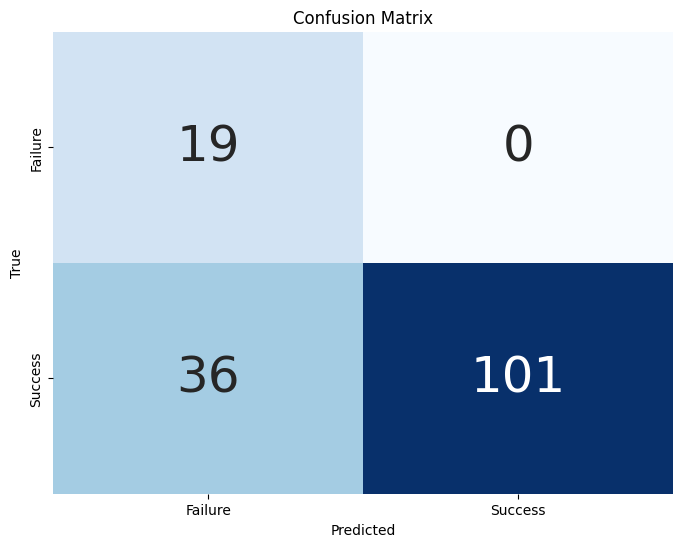

Optimal Threshold: 0.25449988091396203
Balanced Accuracy: 0.8686131386861313
Specificity: 1.0
Sensitivity: 0.7372262773722628


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


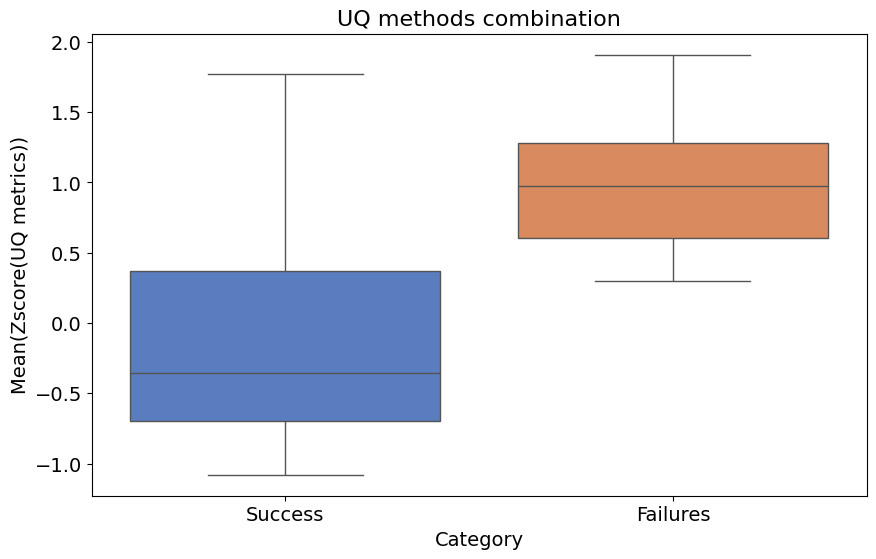

0.8786016135228583
organamnist


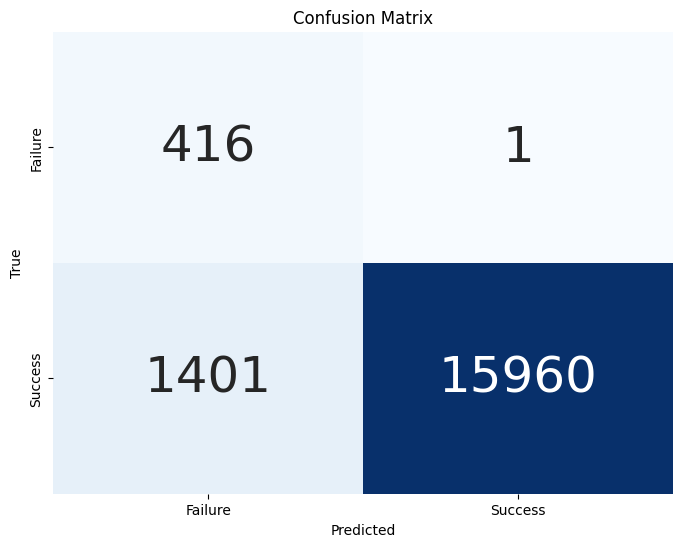

Optimal Threshold: 0.6837258414892615
Balanced Accuracy: 0.9584519009986412
Specificity: 0.9976019184652278
Sensitivity: 0.9193018835320546


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


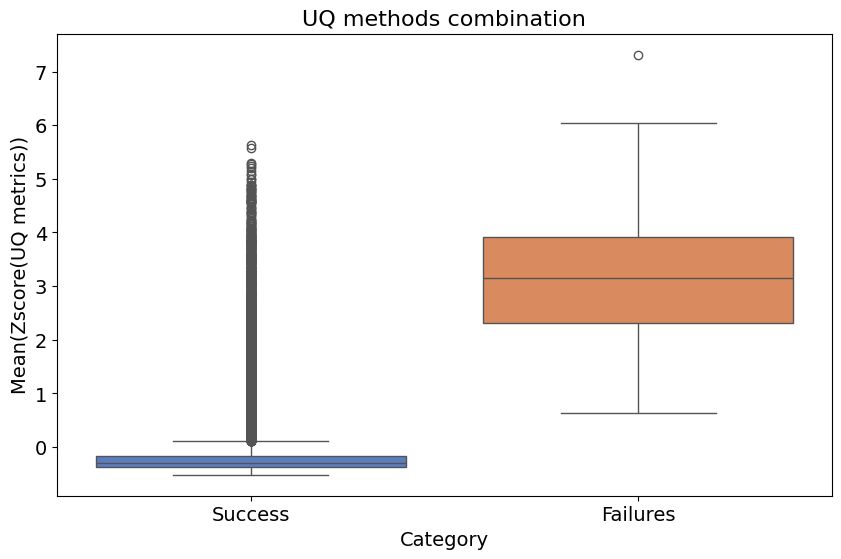

0.9819873839998332
pneumoniamnist


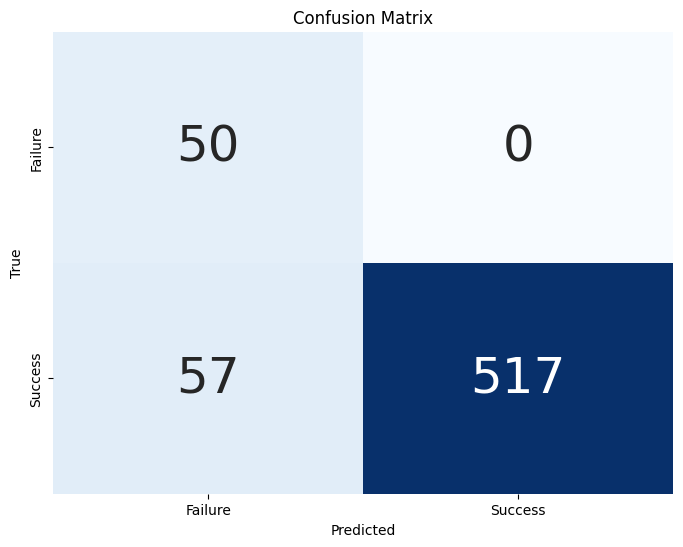

Optimal Threshold: 0.5801669217714855
Balanced Accuracy: 0.9503484320557491
Specificity: 1.0
Sensitivity: 0.9006968641114983


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


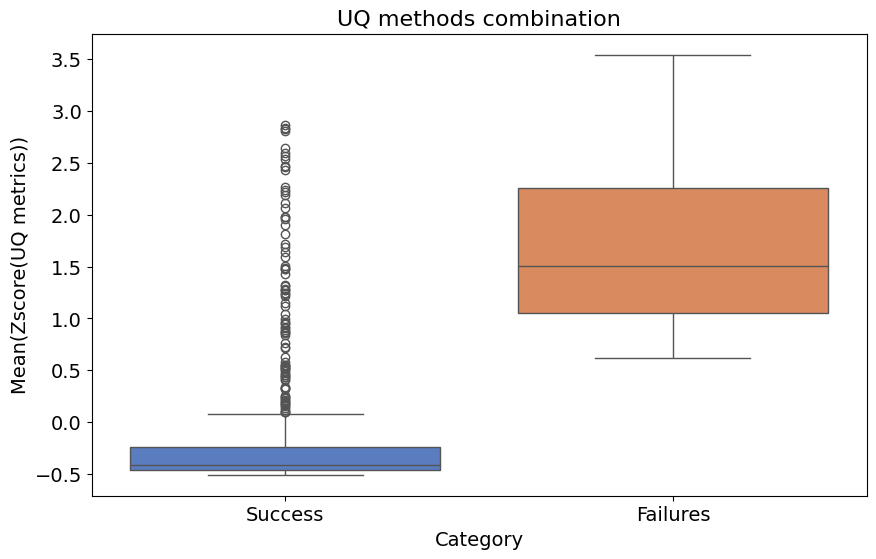

0.9513588850174216
dermamnist


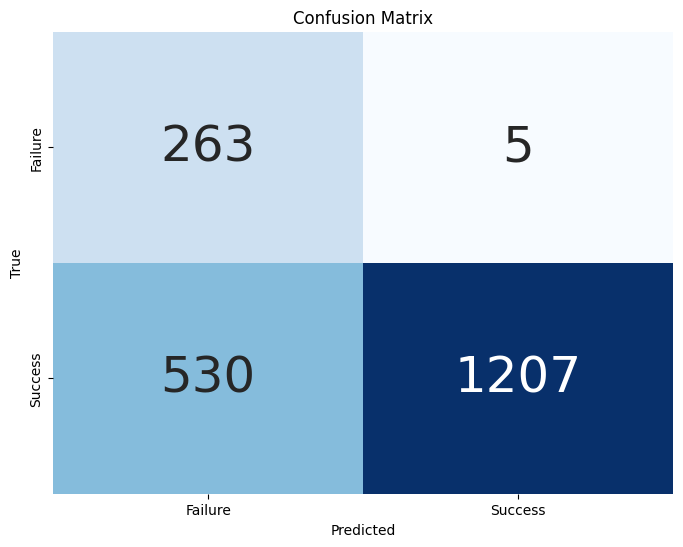

Optimal Threshold: -0.20226700109038165
Balanced Accuracy: 0.8381097534778612
Specificity: 0.9813432835820896
Sensitivity: 0.6948762233736328


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


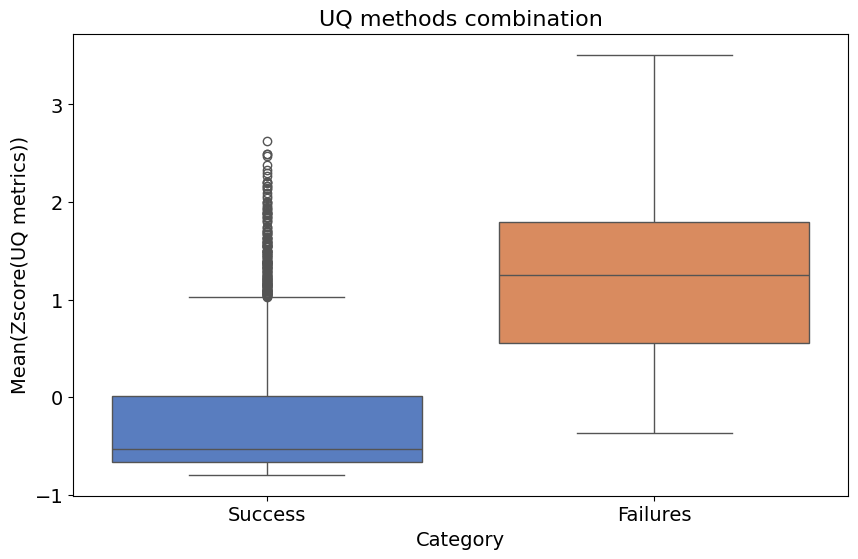

0.9024931473891338
octmnist


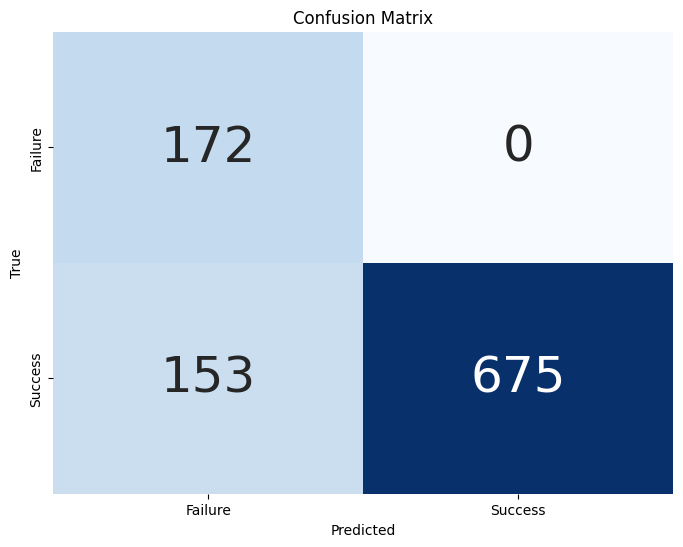

Optimal Threshold: -0.034692134303428546
Balanced Accuracy: 0.9076086956521738
Specificity: 1.0
Sensitivity: 0.8152173913043478


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


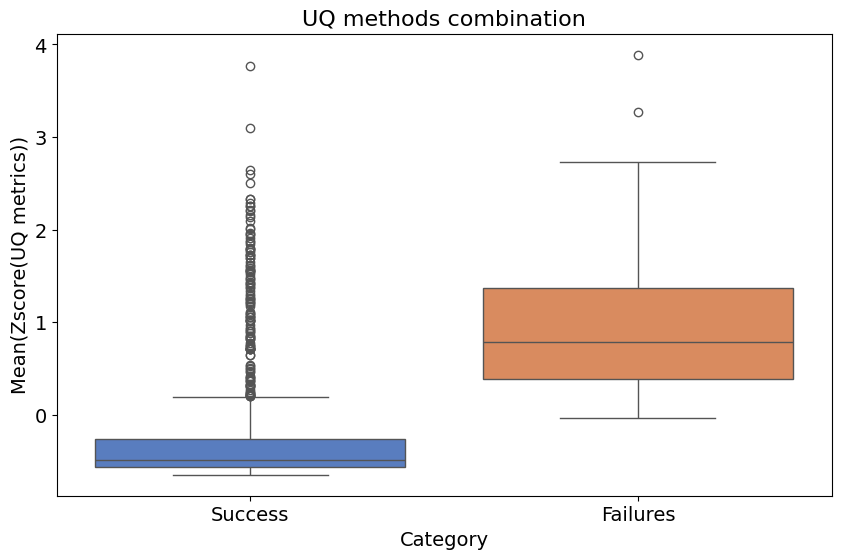

0.9031499269744973
pathmnist


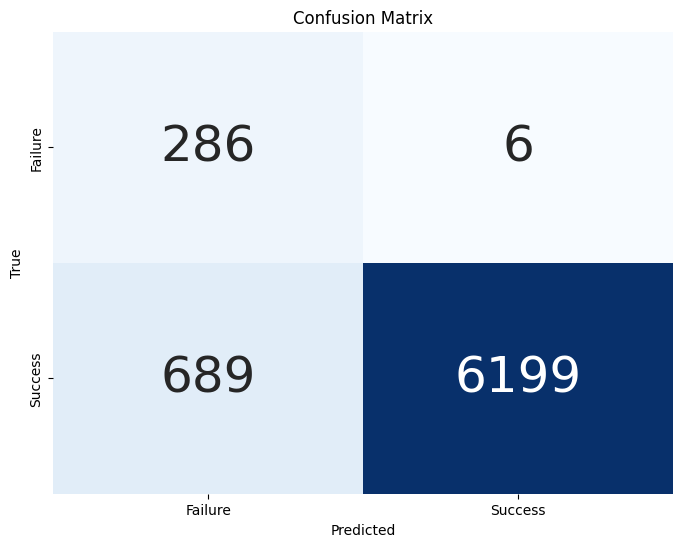

Optimal Threshold: 0.5127396399169095
Balanced Accuracy: 0.9397115093949374
Specificity: 0.9794520547945206
Sensitivity: 0.8999709639953543


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


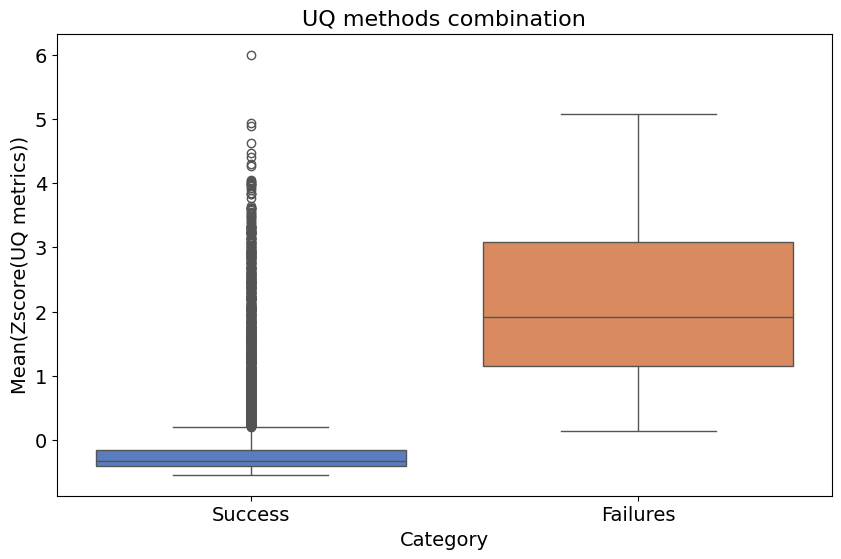

0.9602132157574023
bloodmnist


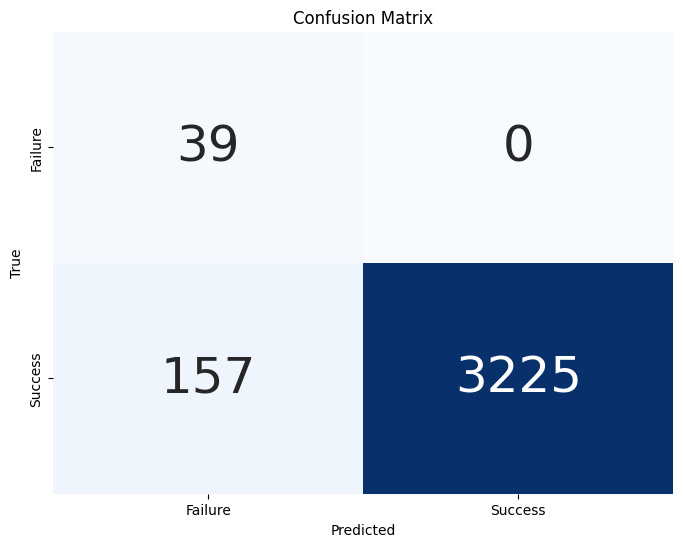

Optimal Threshold: 1.0326790676546915
Balanced Accuracy: 0.976788882318155
Specificity: 1.0
Sensitivity: 0.9535777646363098


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


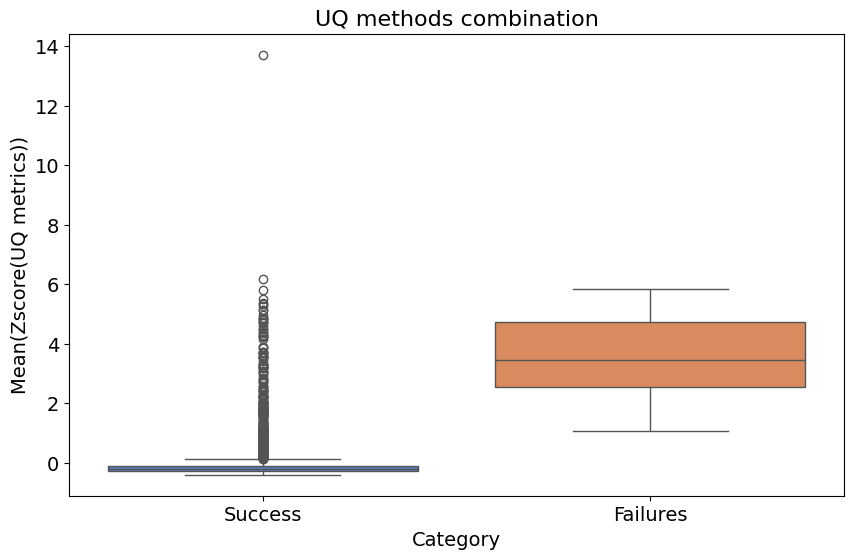

0.9863909991053692
tissuemnist


KeyboardInterrupt: 

In [17]:
for flag in flags:
    print(flag)
    display_UQ_results(mean_values_flags[flag], correct_predictions[flag], incorrect_predictions[flag], 'Mean(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='balanced_accuracy', swarmplot=False)